In [1]:
import numpy as np
import pandas as pd
from gurobipy import *


# Question 1

In [2]:
# read in sushi info
sushi_info = pd.read_csv('sushi_info.csv', names=['Name', 'Category Code', 'Price'])

# function to get sushi names from numbers
def get_names(sushi_info, S):
    # sushi info = sushi info df
    # S = list of sushi numbers for which to get names
    
    # adjust for Python index
    S = [sushi-1 for sushi in S]
    # subset dataframe
    sushi_info = sushi_info.loc[S]
    # return series of sushi names
    return sushi_info['Name']


## Part 1: Understanding the data

(a)

In [3]:
# read in sushi utilities
sushi_utils = pd.read_csv('sushi_utilities_mat.csv',
                          names=[i for i in range(100)])
# convert to numpy array
sushi_utils = np.asarray(sushi_utils)
# extract utilities for customer 1
c1 = sushi_utils[0]
# determine 5 most preferred sushis for customer 1 (index 0 --> customer 1, ascending --> last 5)
top_5_c1 = np.argsort(c1)[-5:]
# reverse array since highest utility is at the bottom, add 1 to adjust index
top_5_c1 = np.flip(top_5_c1) + 1

# diaplay sushi numbers
print(top_5_c1)
# display sushi names
print(get_names(sushi_info, top_5_c1))


[38  4  3 16 44]
37    negi_toro
3           ika
2        maguro
15        samon
43        inari
Name: Name, dtype: object


(b)

In [4]:
# extract utilities for customer 2
c2 = sushi_utils[1]
# determine 5 least preferred sushis for customer 2 (index 1 --> customer 2, ascending --> first 5)
# also add 1 to adjust index
top_5_c2 = np.argsort(c2)[:5] + 1
# no need to reverse array since lowest utility is at the top already
print(top_5_c2)
# display sushi names
print(get_names(sushi_info, top_5_c2))


[94 50 93 15 17]
93         karasumi
49    komochi_konbu
92           kyabia
14            awabi
16         kazunoko
Name: Name, dtype: object


(c)

In [5]:
# get argsort vals for each customer
argsort_utils = np.argsort(sushi_utils, axis=1)
# get ranks of each sushi for each customer
rank_utils = np.argsort(argsort_utils, axis=1)
# average ranks across all customers
mean_ranks = np.mean(rank_utils, axis=0)
# extract top 5, reverse to get best first, add 1 to adjust for index
top_5 = np.flip(np.argsort(mean_ranks)[-5:]) + 1
print(top_5)

# investigate the top 5 sushis
sushi_descr = pd.read_csv('sushi_descriptions.csv', names=[0])
# print out fish type for each top sushi
print('Descriptions of top 5:')
for sushi in top_5:
    print('\t' + str(sushi_descr.loc[sushi][0]))
    
# display sushi names
print(get_names(sushi_info, top_5))


[38  3 80 62  1]
Descriptions of top 5:
	negi_toro (fatty flesh of tuna minced to a paste and mixed with chopped green leaves of Welsh onions)
	maguro (tuna)
	kurumaebi (prawn)
	negi_toro_maki (roll style of no.37)
	ebi (shrimp)
37         negi_toro
2             maguro
79         kurumaebi
61    negi_toro_maki
0                ebi
Name: Name, dtype: object


(d)

In [6]:
# grab index of lowest utility, add 1 to adjust for index
worst = np.argsort(mean_ranks)[0] + 1
print(worst)
# display sushi name
print(get_names(sushi_info, [worst]))


93
92    kyabia
Name: Name, dtype: object


(e)

In [7]:
# aggregate across customers via standard deviation
std_dev_utils = np.std(rank_utils, axis=0)
# extract sushi with highest standard deviation of rank, adjust for index
most_controv = np.argmax(std_dev_utils) + 1
print(most_controv)
# display sushi name
print(get_names(sushi_info, [most_controv]))


15
14    awabi
Name: Name, dtype: object


## Part 2: Common-sense solutions

In [8]:
# read in price data
sushi_info = pd.read_csv('sushi_info.csv', names=['Name', 'Category Code', 'Price'])
# extract prices as numpy array
sushi_prices = np.asarray(sushi_info['Price'])


Create a function that computes the expected per-customer revenue
of an assortment of sushi items S, where each customer is picking the option that gives them the
highest utility.

In [9]:
def per_cust_rev(sushi_utils, sushi_prices, S):
    # computes per customer revenue of some assortment S
    # sushi_utils = k x n matrix of sushi utilities (k = # of customers, n = # of sushis)
    # sushi_prices = n x 1 vector of sushi prices
    # S = a set of sushis offered
    
    # define no-purchase utility
    no_purch_util = 3
    # variable that will store total revenue
    total_rev = 0
    # number of customers
    num_cust = len(sushi_utils)
    # list of customers
    customers = [i for i in range(num_cust)]
    # convert assortment to numpy array so we can index with it, adjust for Python indexing
    S = np.array(list(S)) - 1
    
    # for each customer...
    for cust in customers:
        
        # extract utilities for this customer
        this_cust_utils = sushi_utils[cust, S]
        # if highest utility is greater than the no-purchase option...
        if np.max(this_cust_utils) > no_purch_util:
            
            # extract index of the highest utility (i.e. their preferred sushi)
            sushi_pref = np.argmax(this_cust_utils)
            # extract price
            price = sushi_prices[S[sushi_pref]]
            # track total revenue
            total_rev += price
            
    # adjust total revenue for number of customers (i.e. find per customer revenue)
    per_cust_rev = total_rev / num_cust
    
    return per_cust_rev

# check function
test_S = set([i for i in range(1,6)])
print(per_cust_rev(sushi_utils, sushi_prices, test_S))


14.239620000000011


(a)

In [10]:
# offer all sushis
all_S = set([i+1 for i in range(len(sushi_utils[0]))])
# calculate revenue
print(per_cust_rev(sushi_utils, sushi_prices, all_S))


21.50971999999996


(b)

In [11]:
# offer only the 10 highest revenue sushis
top_10_rev_S = np.flip(np.argsort(sushi_prices))[:10] + 1
print(top_10_rev_S)
print(get_names(sushi_info, top_10_rev_S))
# calculate revenue
print(per_cust_rev(sushi_utils, sushi_prices, set(top_10_rev_S)))


[ 9 15 48 13  5 80 20 47 21 42]
8           toro
14         awabi
47    tarabagani
12        akagai
4            uni
79     kurumaebi
19      chu_toro
46        suzuki
20        hirame
41      botanebi
Name: Name, dtype: object
25.639439999999993


(c)

In [12]:
# set to store highest utilities for each customer
pref_utils_S = set()

# for each customer
for cust in [i for i in range(500)]:
    
    # get utilities for this customer
    this_cust = sushi_utils[cust]
    # compute sushi of max utility
    sushi_max_util = np.argmax(this_cust) + 1
    # add this sushi to set
    pref_utils_S.add(sushi_max_util)
    
print(per_cust_rev(sushi_utils, sushi_prices, pref_utils_S))


21.50971999999996


See (d) and (e) on answer sheet.

## Part 3: An integer optimization model

See (a) on answer sheet.

(b)

In [13]:
# initialize no-purchase utility column
no_purch_col = np.array([3 for i in range(500)]).reshape(500,1)
# add no-purchase column to utilities matrix
sushi_utils_np = np.hstack((sushi_utils, no_purch_col))
# check first 5 vals of no-purchase column
print(sushi_utils_np[:5,100])
# check shape
print(sushi_utils_np.shape)
                                 

[3. 3. 3. 3. 3.]
(500, 101)


The relaxation of the assortment optimization problem:

In [14]:
# initialize model
m_relaxed = Model()

# define dimension variabes
n_sushis = 100
n_cust = 500

# create decision variables, don't enforce them to be binary since this is the relaxation
x = m_relaxed.addVars(n_sushis, ub=1)
y = m_relaxed.addVars(n_cust, n_sushis+1, ub=1)

# add the constraints for each customer
for k in range(n_cust):
    
    # every customer makes exactly one choice
    m_relaxed.addConstr(sum(y[k,j] for j in range(n_sushis+1)) == 1)
    # utility of any choice is at least the no-purchase utility
    m_relaxed.addConstr(quicksum(sushi_utils_np[k,j] * y[k,j] for j in range(n_sushis+1)) >= sushi_utils_np[k,n_sushis])
    
    # loop through all sushis
    for i in range(n_sushis):
        
        # choose only from products that are in the assortment
        m_relaxed.addConstr(y[k,i] <= x[i])
        # the utility of any choice is at least the utility of any included sushis
        m_relaxed.addConstr(quicksum(sushi_utils_np[k,j] * y[k,j] for j in range(n_sushis+1)) >= sushi_utils_np[k,i] * x[i] + sushi_utils_np[k,n_sushis] * (1 - x[i]))

# create objective function
m_relaxed.setObjective(quicksum((1 / n_cust) * sushi_prices[i] * y[k,i] for k in range(n_cust) for i in range(n_sushis)), GRB.MAXIMIZE)

# update the model
m_relaxed.update()
# solve the model
m_relaxed.optimize()
    

Using license file C:\Users\HP\gurobi.lic
Academic license - for non-commercial use only - expires 2021-08-07
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 101000 rows, 50600 columns and 5301000 nonzeros
Model fingerprint: 0xf5163430
Coefficient statistics:
  Matrix range     [6e-06, 5e+00]
  Objective range  [2e-02, 7e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 1.75s
Presolved: 101000 rows, 50600 columns, 5301000 nonzeros

Ordering time: 0.78s

Barrier performed 0 iterations in 6.90 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1241 iterations and 6.91 seconds
Optimal objective  3.058751154e+01


In [15]:
# display the objective value
print(f'Optimal objective: ${m_relaxed.objval:.2f}')


Optimal objective: $30.59


See (c) on answer sheet.

(d)

In [16]:
# initialize model
m = Model()

# define dimension variabes
n_sushis = 100
n_cust = 500

# create decision variables
x = m.addVars(n_sushis, vtype=GRB.BINARY)
y = m.addVars(n_cust, n_sushis+1, vtype=GRB.BINARY)

# add the constraints for each customer
for k in range(n_cust):
    
    # every customer makes exactly one choice
    m.addConstr(sum(y[k,j] for j in range(n_sushis+1)) == 1)
    # utility of any choice is at least the no-purchase utility
    m.addConstr(quicksum(sushi_utils_np[k,j] * y[k,j] for j in range(n_sushis+1)) >= sushi_utils_np[k,n_sushis])
    
    # loop through all sushis
    for i in range(n_sushis):
        
        # choose only from products that are in the assortment
        m.addConstr(y[k,i] <= x[i])
        # the utility of any choice is at least the utility of any included sushis
        m.addConstr(quicksum(sushi_utils_np[k,j] * y[k,j] for j in range(n_sushis+1)) >= sushi_utils_np[k,i] * x[i] + sushi_utils_np[k,n_sushis] * (1 - x[i]))

# create objective function
m.setObjective(quicksum((1 / n_cust) * sushi_prices[i] * y[k,i] for k in range(n_cust) for i in range(n_sushis)), GRB.MAXIMIZE)

# update the model
m.update()
# solve the model
m.optimize()


Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 101000 rows, 50600 columns and 5301000 nonzeros
Model fingerprint: 0x8fa1839e
Variable types: 0 continuous, 50600 integer (50600 binary)
Coefficient statistics:
  Matrix range     [6e-06, 5e+00]
  Objective range  [2e-02, 7e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 71688 rows and 35858 columns (presolve time = 5s) ...
Presolve removed 73053 rows and 36667 columns
Presolve time: 9.08s
Presolved: 27947 rows, 13933 columns, 411684 nonzeros
Variable types: 0 continuous, 13933 integer (13933 binary)
Found heuristic solution: objective 4.0621800
Found heuristic solution: objective 21.5232800

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7270400e+00   6

In [17]:
# display the objective value
print(f'Optimal objective: ${m.objval:.2f}')


Optimal objective: $26.24


(e)

In [18]:
# extract the optimal assortment of sushis (add 1 to adjust for Python indexing)
optimal_S = [i+1 for i in range(n_sushis) if x[i].x > 0.5]
print(f'Optimal assortment: {optimal_S}')

# check with revenue calculation function
print(per_cust_rev(sushi_utils, sushi_prices, set(optimal_S)))


Optimal assortment: [9, 15, 19, 36, 48, 73, 76, 88, 90, 98]
26.244539999999823


In [19]:
# get optimal assortment in terms of sushi names

# adjust for Python index
optimal_S_adj = [sushi-1 for sushi in optimal_S]
# subset dataframe
optimal_sushis = sushi_info.loc[optimal_S_adj]
# display sushi names
optimal_sushis['Name']


8              toro
14            awabi
18             saba
35         kanimiso
47       tarabagani
72    mentaiko_maki
75       ika_nattou
87           tobiuo
89         mamakari
97           namako
Name: Name, dtype: object

# Question 2

# Part 1: Formulating a Basic Newsvendor Model

In [20]:
# cost of a regular nurse
cost_reg = 2160
# cost of an agency nurse
cost_ag = 5400

# function to calculate total cost
def calc_cost(num_staffed, num_cases):
    
    # cost from staffed nurses
    total_reg = num_staffed * 2160
    # cost from agency nurses
    if num_cases > num_staffed:
        diff = num_cases - num_staffed
        total_ag = diff * 5400
    else:
        total_ag = 0
        
    return total_reg + total_ag


(a)

In [21]:
print(calc_cost(18, 12))


38880


(b)

In [22]:
print(calc_cost(5, 8))


27000


(c)

Recall the cost-minimization formulation:

$$ \min_{Q} \mathbb{E}[c_{u}(D-Q)^{+} + c_{o}(Q-D)^{+}] $$

See rest of (c) on answer sheet.

## Part 2: Solving the Basic Newsvendor Model

Split the data into a training set and a test set, so that the training set consists of the first 200 days of data, and the test set consists of the last 100 days of data.

In [23]:
# read in data
nurse = pd.read_csv('nurse.csv')
# split into first 200 (train) and last 100 (test) days
train = nurse[nurse['Day'] <= 200]
test = nurse[nurse['Day'] > 200]
# split into X and y variables
X_train = train.drop(columns=['DailyED', 'Day'])
X_test = test.drop(columns=['DailyED', 'Day'])
y_train = train['DailyED']
y_test = test['DailyED']


(a)

In [24]:
# determine quantile based on overage and underage costs
c_o = 2160
c_u = 5400 - c_o
quantile = c_u / (c_u + c_o)
print(quantile)


0.6


(b)

In [25]:
# determine optimal staffing level based on empirical distribution of training set
level_basic = round(np.quantile(y_train, quantile))
print(level_basic)


16


(c)

In [26]:
# find average cost of this staffing level based on training set
train_set_cost_ordinary = c_u * np.maximum(y_train - level_basic, 0) + c_o * np.maximum(level_basic - y_train, 0) + c_o * y_train
avg_train_set_cost_ordinary = train_set_cost_ordinary.mean(axis = 0)
print(avg_train_set_cost_ordinary)


41256.0


(d)

In [27]:
# find average cost of this staffing level based on test set
test_set_cost_ordinary = c_u * np.maximum(y_test - level_basic, 0) + c_o * np.maximum(level_basic - y_test, 0) + c_o * y_test
avg_test_set_cost_ordinary = test_set_cost_ordinary.mean(axis = 0)
print(avg_test_set_cost_ordinary)


39528.0


## Part 3: Solving the Contextual Newsvendor Model

Using the training set, build a regression tree to predict DailyED. Use a maximum depth of 2.

In [28]:
from sklearn.tree import DecisionTreeRegressor
# initialize tree
dt = DecisionTreeRegressor(max_depth=2)
# fit tree
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=2)

(a)

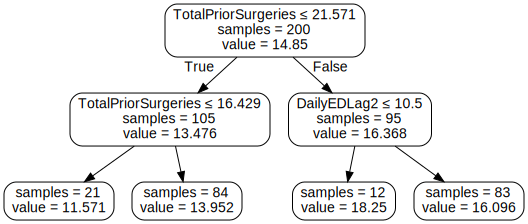

In [29]:
# determine which variables the tree splits on via graphviz
import graphviz 
from sklearn.tree import export_graphviz
tree_viz = export_graphviz(dt, out_file=None,
                                feature_names=X_train.columns, impurity = False, 
                                   rounded=True,  
                                  special_characters=True) 
graph = graphviz.Source(tree_viz) 
graph.render("Nurse Staffing") 
graph


(b)

In [30]:
# get condtional distribution (i.e. staffing level) for each leaf

# find out to which leaf each sample maps
leaf_mapping = dt.apply(X_train)
# get indices of leaves
leaves = [i for i in range(dt.tree_.node_count) if dt.tree_.children_left[i] == -1]
# initialize array that maps each leaf to a quantile
leaf_to_quantile = np.zeros(dt.tree_.node_count)
# populate mapping array
for leaf in leaves:
    # extract boolean array of samples that map to the current leaf
    idx = (leaf == leaf_mapping)
    # get values of those samples
    y_leaf = y_train[idx]
    # store quantile of those samples in mapping array
    leaf_to_quantile[leaf] = round(np.quantile(y_leaf, quantile))

# display mapping
leaf_to_quantile


array([ 0.,  0., 13., 15.,  0., 18., 17.])

(c)

In [31]:
# find average cost based on training set

# map samples to leaves
train_leaves = dt.apply(X_train)
# determine staffing choices
train_decisions = leaf_to_quantile[train_leaves]
# calculate cost
train_set_cost = c_u * np.maximum(y_train - train_decisions, 0) + c_o * np.maximum(train_decisions - y_train, 0) + c_o * y_train
# take average
avg_train_set_cost = train_set_cost.mean(axis = 0)
print(avg_train_set_cost)


40554.0


(d)

In [32]:
# find average cost based on test set

# map samples to leaves
test_leaves = dt.apply(X_test)
# determine staffing choices
test_decisions = leaf_to_quantile[test_leaves]
# calculate cost
test_set_cost = c_u * np.maximum(y_test - test_decisions, 0) + c_o * np.maximum(test_decisions - y_test, 0) + c_o * y_test
# take average
avg_test_set_cost = test_set_cost.mean(axis = 0)
print(avg_test_set_cost)


38772.0
